In [56]:
from keras.layers import *
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.animation as animation
from pylab import *
import io
import base64
from IPython.display import HTML
import pickle
from keras.layers.merge import dot, Dot
from scipy.spatial.distance import cosine
from perso import *
import skimage.io

In [3]:
def save_clip(video, save_path = 'demo.mp4', fps = 30):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(video[0],cmap='gray',interpolation='nearest')
    im.set_clim([0,1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        tmp = video[n]
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,video.shape[0],interval=1)
    #writer = animation.writers['ffmpeg'](fps=fps)
    #ani.save(save_path,writer=writer,dpi=100)
    return ani

In [608]:
animation.writers.list()

[u'html', u'pillow']

In [34]:
def add_conv(y, filters, kernel_size = (3,3), conv_strides = (2,2), pool_strides = False, batch_norm = True, dropout = False, input_shape = None, activation = 'lrelu'):
    y = Conv2D(int(filters), kernel_size, strides=conv_strides, padding='same')(y)
    if batch_norm:  y = BatchNormalization()(y)
    if activation != None and activation != 'lrelu': y = Activation(activation)(y)
    elif activation == 'lrelu': y = LeakyReLU(alpha=0.2)(y)
    if dropout: y = Dropout(dropout)(y)
    if pool_strides: y = MaxPooling2D(strides = pool_strides)(y)
    return y


def filter_gen(n, reverse = False, base = 32):
    flt = base
    filters = []
    for x in range(n):
        filters.append(flt)
        flt *= 2
    if reverse: filters.reverse()
    return filters

def add_res_block(y, filters, kernel_size = (3,3), strides = (1,1),**kwargs):
    shortcut = y
    y = add_conv(y, filters, kernel_size = kernel_size, conv_strides = strides, pool_strides = False, dropout = False, **kwargs)
    y = add_conv(y, filters, kernel_size = kernel_size, conv_strides = strides, pool_strides = False, dropout = False, activation = None, **kwargs)
    y = Add()([shortcut, y])
    y = Activation('relu')(y)
    return y


def add_deconv(y, filters, kernel_size = (2,2), strides = (2,2), batch_norm = True, activation = 'lrelu', dropout = False):
    y = Conv2DTranspose(filters,kernel_size = kernel_size, strides = strides)(y)
    if batch_norm: y = BatchNormalization()(y)
    if activation != None and activation != 'lrelu': y = Activation(activation)(y)
    elif activation == 'lrelu': y = LeakyReLU(alpha=0.2)(y)
    if dropout: y = Dropout(dropout)(y)
    return y 

def show_array(array):
    return Image.fromarray(np.round(array).astype('uint8'), 'RGB')

In [5]:
class ImageIterator:
    def __init__(self):
        pass
    def next(self): # Python 3: def __next__(self)
        
        data = [(iterator.next()[0] - 127.5) / 127.5]
                
        return data, data

In [6]:
image_size = [128,128]
sortedPath = 'sorted'
dataGen = ImageDataGenerator()
iterator = dataGen.flow_from_directory('data/128x128/', batch_size=32, target_size=[128,128])

Found 24797 images belonging to 4 classes.


[0. 1.]


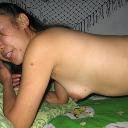

In [5]:
data = iterator.next()
print(data[1][0])
show_array(data[0][0])

In [6]:
def convnet():
    inp = Input(shape=(128,128,3))
    y = add_conv(inp, 16, batch_norm=True)
    for x in filter_gen(2, base = 32):
        y = add_conv(y, x, batch_norm=True)
    inner_matrix = y
    y = Flatten()(y)
    out = Dense(2, activation = 'softmax')(y)
    model = Model(inputs = inp, outputs = out)
    activation_map = Model(inputs = inp, outputs = inner_matrix)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model, activation_map

In [12]:
K.clear_session()    

In [13]:
model, activation_map = convnet()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
__________

In [673]:
data = iterator.next()

In [690]:
data[0].shape

(32, 128, 128, 3)

In [702]:
model.test_on_batch(data[0], data[1])

[8.516065, 0.46875]

In [725]:
model.predict(np.asarray([data[0][0]]))

array([[9.9910945e-01, 8.9053722e-04]], dtype=float32)

In [674]:
data[0].shape

(32, 128, 128, 3)

In [14]:
model.fit_generator(iterator, epochs=5)

Epoch 1/5
299/299 [==============================] - 8s 28ms/step - loss: 0.4640 - acc: 0.8502
Epoch 2/5
299/299 [==============================] - 8s 27ms/step - loss: 0.2647 - acc: 0.9088
Epoch 3/5
299/299 [==============================] - 8s 27ms/step - loss: 0.1828 - acc: 0.9359
Epoch 4/5
299/299 [==============================] - 8s 27ms/step - loss: 0.0942 - acc: 0.9658
Epoch 5/5
299/299 [==============================] - 8s 27ms/step - loss: 0.0679 - acc: 0.9753


In [859]:
data = iterator.next()
model.test_on_batch(data[0],data[1])

[0.0033084177, 1.0]

In [89]:
data = iterator.next()

In [90]:
img = data[0][17]

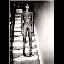

In [91]:
show_array(img)

In [226]:
model.predict(np.array([img]))

array([[1.3591266e-04, 9.9986410e-01]], dtype=float32)

In [15]:
def get_activation_map(img):
    data = activation_map.predict(np.array([img]))[0]
    a = np.sum(data, axis=2)
    b = a .flatten()
    m = b[np.argmax(b)]
    a = a / m
    a = a*255
    a = np.reshape(a, (16,16,1))
    b = np.zeros((16,16,2))
    a = np.concatenate([a,b], axis=2).astype('uint8')
    a = K.cast(a, 'int32')
    a = K.expand_dims(a,axis=0)
    a = K.resize_images(a,height_factor=32, width_factor=32,data_format='channels_last')
    a = K.eval(a)[0]
    img = K.cast(img, 'int32')
    img = K.expand_dims(img,axis=0)
    img = K.resize_images(img,height_factor=4, width_factor=4,data_format='channels_last')
    img = K.eval(img)[0]
    return a, img
    
    

In [16]:
def random_activation():
    data = iterator.next()
    img = data[0][0]
    pred = model.predict(np.asarray([img]))[0]
    if np.argmax(pred) == 0: print('dressed')
    else: print('nude')
    mp, img = get_activation_map(img)
    print mp.shape
    print img.shape
    panorama = np.concatenate([mp, img], axis=1).astype('uint8')
    flt = mp[:,:,0].astype('float64') / 255 - 0.3
    flt = 1 * (flt > 0)
    mask = np.zeros(shape=img.shape)
    for row in range(img.shape[0]):
        for pixel in range(img.shape[1]):
            if flt[row][pixel] == 1:
                mask[row][pixel] = img[row][pixel]
    return show_array(mask)

dressed
(512, 512, 3)
(512, 512, 3)


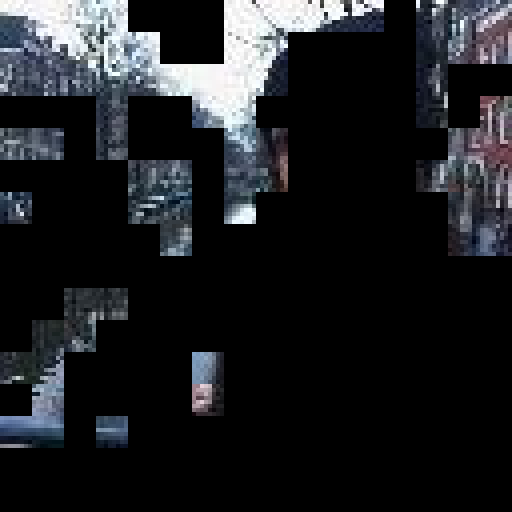

In [17]:
random_activation()

In [7]:
def preprocess_img(img):
    return (img.astype('float64') - 127.5) / 127.5

In [8]:
def deprocess_img(img):
    img = img * 127.5 + 127.5
    return img.astype('uint8')

In [388]:
    def autoencoder():
    encoder_inp = Input(shape=(128,128,3))
    y = add_conv(encoder_inp, 32)
    y = add_conv(y, 64)
    y = add_conv(y, 128, pool_strides=False)
    y = Flatten()(y)
    vec = Dense(1024, activation = 'tanh')(y)
    encoder = Model(inputs = encoder_inp, outputs = vec)
    
    decoder_inp = Input(shape=(1024,))
    y = Dense(16384)(decoder_inp)
    y = LeakyReLU(alpha=0.2)(y)
    y = Reshape((16,16,64))(y)
    y = add_conv(y, 128, conv_strides=(1,1))
    y = add_deconv(y, 64)
    y = add_deconv(y, 32)
    decoder_out = add_deconv(y, 3, activation='tanh')
    decoder = Model(inputs = decoder_inp, outputs = decoder_out)
    
    inp = Input(shape = (128,128,3))
    y = encoder(inp)
    out = decoder(y)
    
    autoencoder = Model(inputs = inp, outputs = out)
    optimizer = Adam(clipvalue=0.1)
    autoencoder.compile(loss='mse', optimizer=optimizer)
    print(encoder.summary())
    print(decoder.summary())
    print(autoencoder.summary())
    return autoencoder, encoder, decoder

In [46]:
def autoencoder2():
    encoder_inp = Input(shape=(128,128,3))
    y = add_conv(encoder_inp, 32)
    y = add_conv(y, 64, conv_strides = (1,1))
    for x in range(2):
        y = add_res_block(y, 64)
    
    vec = add_conv(y,filters=1, conv_strides=(1,1), activation = None)
    encoder = Model(inputs = encoder_inp, outputs = vec)
    
    decoder_inp = Input(shape=(64,64,1))
    y = decoder_inp
    for x in range(2):
        y = add_res_block(y, 64)
    y = add_deconv(y, 32)
    decoder_out = add_deconv(y, 3, activation='tanh', strides = (1,1))
    decoder_out = Cropping2D(cropping = ((0,1),(0,1)))(decoder_out)
    decoder = Model(inputs = decoder_inp, outputs = decoder_out)
    inp = Input(shape = (128,128,3))
    y = encoder(inp)
    print y
    out = decoder(y)
    
    autoencoder = Model(inputs = inp, outputs = out)
    optimizer = Adam()
    autoencoder.compile(loss='mse', optimizer=optimizer)
    print(encoder.summary())
    print(decoder.summary())
    print(autoencoder.summary())
    return autoencoder, encoder, decoder
    

In [4]:
def sampling(args):
    z_mean, z_log_sigma = args
    #batch = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_sigma) * epsilon

In [97]:
def variational_autoencoder():
    input_shape = (128,128,3)
    latent_dim = (128,128,1)
    encoder_inp = Input(shape=input_shape)
    y = add_conv(encoder_inp, 32, conv_strides = (1,1))
    #y = add_conv(y, 32)
    y = add_conv(y, 64, conv_strides = (1,1))
    for x in range(4):
        y = add_res_block(y, 64)
    
    z_mean = add_conv(y,filters=1, conv_strides=(1,1), activation = None)
    z_log_sigma = add_conv(y,filters=1, conv_strides=(1,1), activation = None)
    vec = Lambda(sampling, output_shape=latent_dim)([z_mean, z_log_sigma])
    encoder = Model(inputs = encoder_inp, outputs = vec)
    
    decoder_inp = Input(shape=latent_dim)
    y = decoder_inp
    for x in range(4):
        y = add_res_block(y, 64)
    y = add_deconv(y, 64, strides=(1,1))
    #y = add_deconv(y, 32)
    decoder_out = add_deconv(y, 3, activation='tanh', strides=(1,1))
    decoder_out = Cropping2D(cropping = ((1,1),(1,1)))(decoder_out)
    decoder = Model(inputs = decoder_inp, outputs = decoder_out)
    inp = Input(shape = input_shape)
    y = encoder(inp)
    print y
    out = decoder(y)
    
    autoencoder = Model(inputs = inp, outputs = out)
    optimizer = Adam(0.001, 0.9, 0.98, epsilon=1e-9)
    autoencoder.compile(loss='mse', optimizer=optimizer)
    print(encoder.summary())
    print(decoder.summary())
    print(autoencoder.summary())
    return autoencoder, encoder, decoder

In [86]:
K.clear_session()

In [98]:
autoencoder, encoder, decoder = variational_autoencoder()

Tensor("model_10/lambda_4/add:0", shape=(?, 128, 128, 1), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 128, 128, 32) 896         input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_40 (LeakyReLU)      (None, 128, 128, 32) 0           conv2d_73[0][0]                  
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 128, 128, 64) 18496       leaky_re_lu_40[0][0]             
____________________________________

In [18]:
def autoencoder_gen():
    data = (iterator.next()[0] - 127.5) / 127.5
    yield [data,data]

In [17]:
class ImageIterator:
    def __init__(self):
        pass
    def __next__(self): # Python 3: def __next__(self)
        data = (iterator.next()[0] - 127.5) / 127.5
        return data, data

In [19]:
def show_encoded_array(array):
    array = array * 127.5 + 127.5
    return show_array(array)

In [16]:
def show_random_encoded_array():
    img = autoencoder_iterator.next()[0][0]
    array = autoencoder.predict(np.array([img]))[0]
    panorama = np.concatenate([array, img], axis=1)
    panorama = K.cast(panorama, 'float64')
    panorama = K.expand_dims(panorama,axis=0)
    panorama = K.resize_images(panorama, height_factor=8, width_factor=8, data_format='channels_last')
    panorama = K.eval(panorama)[0]
    return show_encoded_array(panorama)

In [66]:
class ImageIterator():
    def __init__(self, path, batch_size=32, shuffle = False, ext = '.png', max_n = 9999999):
        self.batch_size = batch_size
        self.path = path
        self.shuffle = shuffle
        self._n = 0
        self.max_n = getLastFromDir(path)
        if self.max_n > max_n: self.max_n = max_n
        self.ext = ext
        self.epochs = 0
    
    def next(self):
        data = []
        for x in range(self.batch_size):
            img = skimage.io.imread(self.path+'/{}'.format(self._n)+self.ext)
            img = (img - 127.5) / 127.5
            data.append(img)
            self._n +=1
            if self._n > self.max_n: 
                self._n = 0
                self.epochs += 1
        return np.asarray(data)
    
class MultpileClassesImageIterator():
    def __init__(self, path1, path2, **kwargs):
        self.X_iterator = ImageIterator(path1, **kwargs)
        self.y_iterator = ImageIterator(path2, **kwargs)
        if self.X_iterator.max_n > self.y_iterator.max_n: self.X_iterator.max_n = self.y_iterator.max_n
        else: self.y_iterator.max_n = self.X_iterator.max_n
    def next(self):
        return self.X_iterator.next(), self.y_iterator.next()   

In [75]:
autoencoder_iterator = MultpileClassesImageIterator('data/128x128/cropped/nude/backgrounds', 'data/128x128/cropped/black/persons')

In [93]:
x,y = autoencoder_iterator.next()

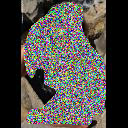

In [95]:
show_encoded_array(x[10])

In [120]:
early_stopping = EarlyStopping(patience=5)
model_checkpoint = ModelCheckpoint(filepath='variational5.ckpt', save_best_only=True, monitor='loss', verbose=1)
autoencoder.fit_generator(autoencoder_iterator, steps_per_epoch=281, epochs=100, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
281/281 [==============================] - 352s 1s/step - loss: 0.0224

Epoch 00001: loss improved from inf to 0.02243, saving model to variational5.ckpt
Epoch 2/100
281/281 [==============================] - 354s 1s/step - loss: 0.0220

Epoch 00002: loss improved from 0.02243 to 0.02198, saving model to variational5.ckpt
Epoch 3/100
281/281 [==============================] - 354s 1s/step - loss: 0.0225

Epoch 00003: loss did not improve from 0.02198
Epoch 4/100
281/281 [==============================] - 354s 1s/step - loss: 0.0221

Epoch 00004: loss did not improve from 0.02198
Epoch 5/100
281/281 [==============================] - 354s 1s/step - loss: 0.0241

Epoch 00005: loss did not improve from 0.02198
Epoch 6/100
281/281 [==============================] - 354s 1s/step - loss: 0.0229

Epoch 00006: loss did not improve from 0.02198
Epoch 7/100
281/281 [==============================] - 354s 1s/step - loss: 0.0221

Epoch 00007: loss did not improve from 0.02198
Epoch 8/1

KeyboardInterrupt: 

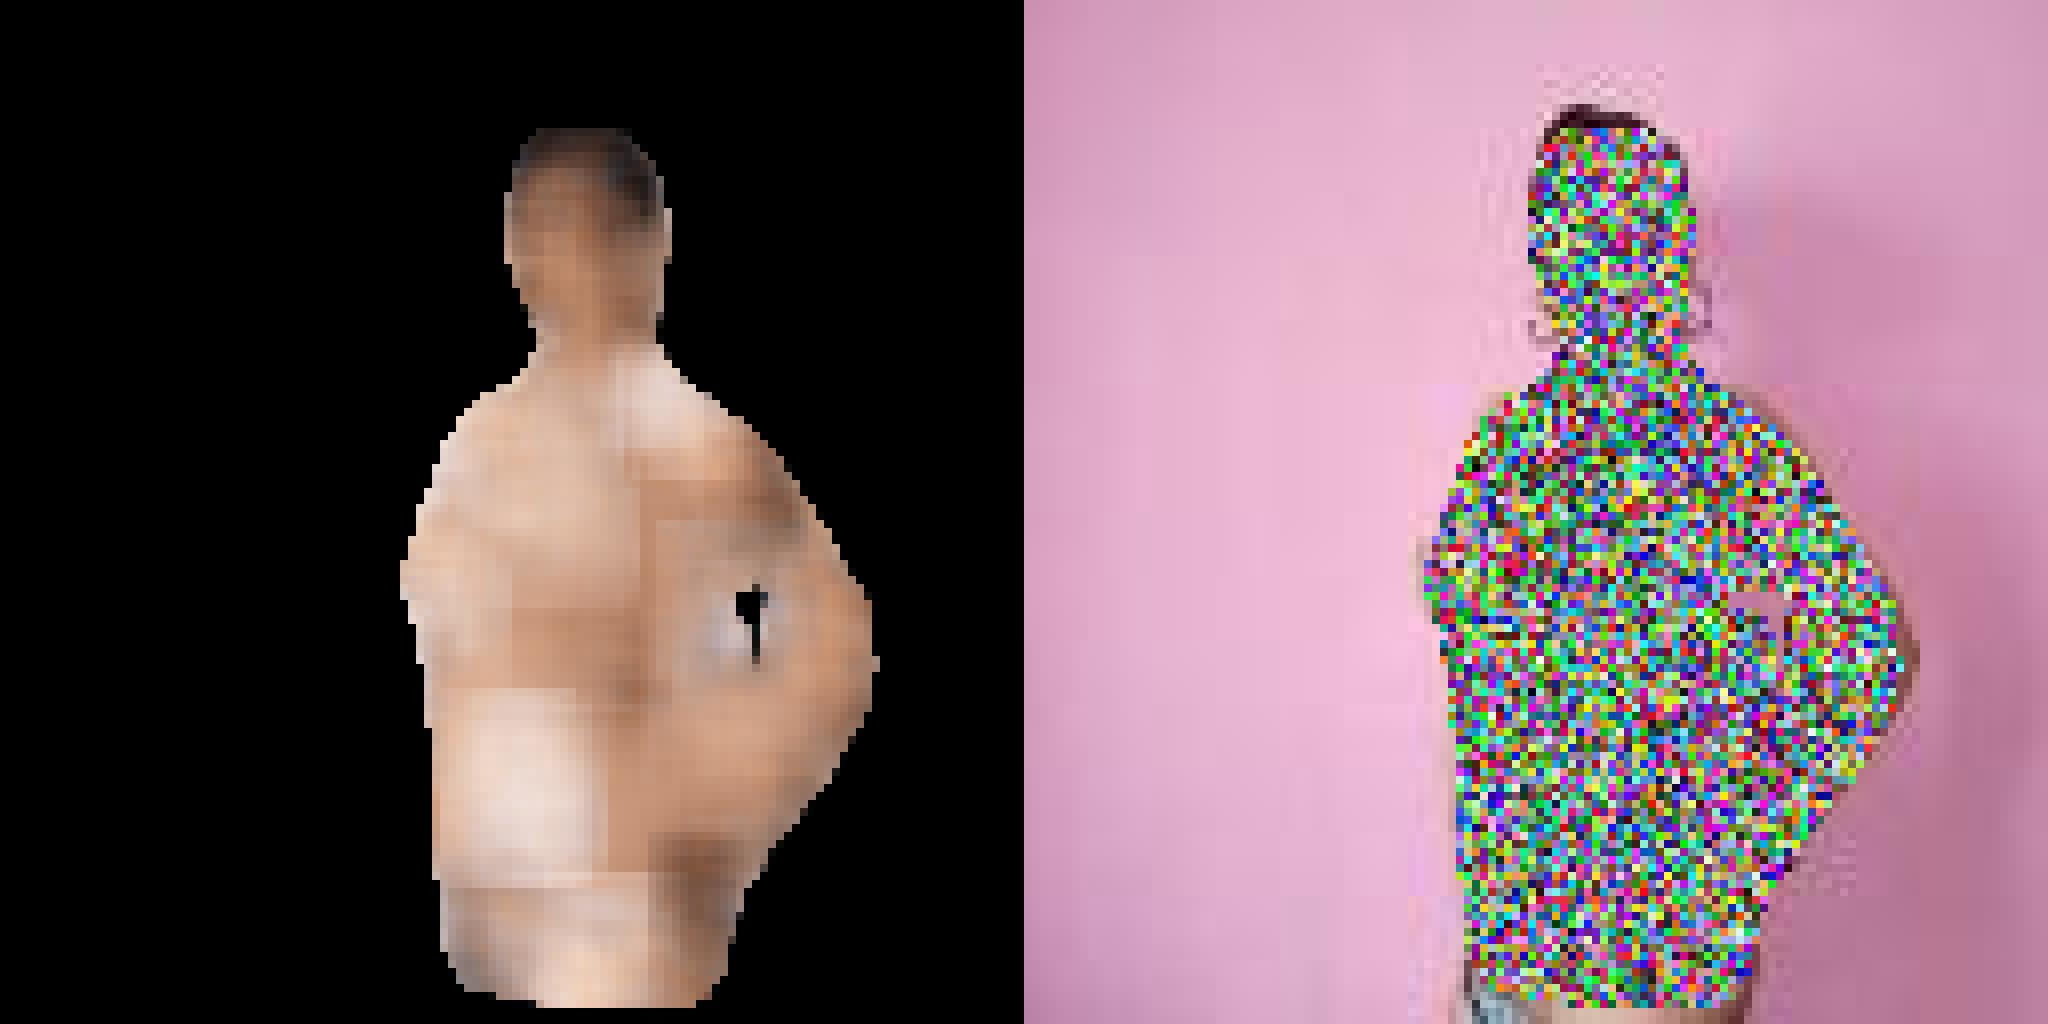

In [128]:
show_random_encoded_array()

In [185]:
def get_image_vector(img):
    preprocessed = preprocess_img(img)
    return encoder.predict(np.array([preprocessed]))[0]

In [186]:
def decode_image_vector(vector):
    return deprocess_img(decoder.predict(np.array([vector]))[0])

In [187]:
def image_transition(img1, img2, save_path = 'demo.mp4'):
    encoded_img1 = np.round(get_image_vector(img1), 8)
    encoded_img2 = np.round(get_image_vector(img2), 8)
    diff = np.round(encoded_img2 - encoded_img1, 8)
    step = np.round(diff / 100, 8)
    #print step
    video = []
    vector = encoded_img1
    for x in range(100):
        vector = np.round(vector + step, 8)
        img = decode_image_vector(vector)
        video.append(img)
    video.reverse()
    video = np.array(video)
    with open('test.p', 'wb') as f:
        pickle.dump(video, f)
    return video

In [188]:
def random_transition_dressed2nude():
    imgs, labels = iterator.next()
    nude = []
    dressed = []
    for x in range(len(imgs)):
        if labels[x][0] == 0: dressed = imgs[x]
        else: nude = imgs[x]
        if nude != [] and dressed != []: break
    return image_transition(dressed, nude)

In [189]:
def sim_model():
    inp1 = Input(shape=(128,128,3))
    inp2 = Input(shape=(128,128,3))
    enc1 = encoder(inp1)
    enc2 = encoder(inp2)
    dist = dot([enc1, enc2], axes=1, normalize=True)
    model = Model(inputs = [inp1, inp2], outputs = dist)
    return model

In [950]:
similarity = sim_model()

In [190]:
video = random_transition_dressed2nude()

/home/jean/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  


In [281]:
iterated = [iterator.next() for x in range(50)]
labels = np.concatenate([iterated[x][1] for x in range(50)], axis=0)[:,0]
imgs= np.concatenate([iterated[x][0] for x in range(50)], axis = 0)
encoded_imgs = encoder.predict(preprocess_img(imgs))
bbs = []
print(len(labels))
for x in range(len(imgs)):
    bb = None
    score = 999999
    for y in range(len(imgs)):
        if y != x and labels[x] != labels[y]:
            s = cosine(encoded_imgs[x].flatten(), encoded_imgs[y].flatten())
            if s < score:
                bb = [x, y, s]
                score = s
    bbs.append(bb)

1600


In [282]:
bbs

[[0, 194, 0.4259302616119385],
 [1, 36, 0.7215190529823303],
 [2, 543, 0.7317679822444916],
 [3, 397, 0.3839395046234131],
 [4, 279, 0.6722748875617981],
 [5, 894, 0.19718921184539795],
 [6, 268, 0.3055559992790222],
 [7, 55, 0.3627222776412964],
 [8, 157, 0.4559464454650879],
 [9, 54, 0.3089626431465149],
 [10, 473, 0.27769339084625244],
 [11, 81, 0.35993051528930664],
 [12, 452, 0.33563750982284546],
 [13, 704, 0.7675503045320511],
 [14, 55, 0.2737697958946228],
 [15, 407, 0.2735777497291565],
 [16, 590, 0.491333544254303],
 [17, 660, 0.41872143745422363],
 [18, 1333, 0.38618892431259155],
 [19, 268, 0.6014192700386047],
 [20, 389, 0.14944219589233398],
 [21, 1012, 0.5715686082839966],
 [22, 909, 0.20180290937423706],
 [23, 1209, 0.5678532421588898],
 [24, 961, 0.4648281931877136],
 [25, 586, 0.46971338987350464],
 [26, 270, 0.33442580699920654],
 [27, 397, 0.525057315826416],
 [28, 1388, 0.3190598487854004],
 [29, 389, 0.36053895950317383],
 [30, 1388, 0.2592199444770813],
 [31, 81,

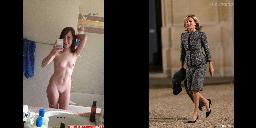

In [286]:
show_array(np.concatenate([imgs[999], imgs[55]], axis=1))

In [284]:
image_transition(imgs[210], imgs[312])

array([[[[12, 11, 11],
         [ 5,  3,  3],
         [ 1,  1,  1],
         ...,
         [ 2,  1,  1],
         [ 4,  2,  3],
         [10,  6,  6]],

        [[ 4,  3,  3],
         [ 3,  1,  2],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 4,  2,  2]],

        [[ 1,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 1,  1,  1]],

        ...,

        [[ 2,  1,  1],
         [ 1,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 1,  1,  1]],

        [[ 3,  2,  2],
         [ 1,  1,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 2,  1,  1]],

        [[ 7,  5,  5],
         [ 3,  2,  2],
         [ 0,  0,  0],
         ...,
         [ 1,  0,  1],
         [ 1,  1,  1],
         [ 4,  3,  3]]],


       [[[12, 11, 11],
         [ 5,  3,  3],
         [ 1, 

In [287]:
encoded_imgs.flatten().sort(axis=0)

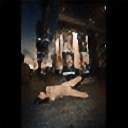

In [290]:
show_encoded_array(decoder.predict(np.array([encoded_imgs[20]]))[0])

In [316]:
class EncodedIterator():
    def __init__(self):
        pass
    def next(self):
        imgs, labels = iterator.next()
        imgs = np.reshape(encoder.predict(preprocess_img(imgs)), (32,4096))
        return imgs, labels

encoded_iterator = EncodedIterator()

In [319]:
def encoded_classifier():
    inp = Input(shape = (4096,))
    y = Dense(1024)(inp)
    y = LeakyReLU(alpha=0.2)(y)
    y = Dense(512)(y)
    y = LeakyReLU(alpha=0.2)(y)
    y = Dense(256)(y)
    y = LeakyReLU(alpha=0.2)(y)
    y = Dense(128)(y)
    y = LeakyReLU(alpha=0.2)(y)
    y = Dense(64)(y)
    y = LeakyReLU(alpha=0.2)(y)
    out = Dense(2, activation = 'softmax')(y)
    model = Model(inputs = inp, outputs = out)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    print(model.summary())
    return model

In [320]:
encoded_classifier = encoded_classifier()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 256)               0         
__________

In [323]:
encoded_classifier.fit_generator(encoded_iterator, steps_per_epoch=281, epochs = 10)

Epoch 1/10
281/281 [==============================] - 21s 74ms/step - loss: 0.1479
Epoch 2/10
152/281 [===============>..............] - ETA: 9s - loss: 0.1285

KeyboardInterrupt: 

In [326]:
def nudifier_model():
    modifier_inp = Input(shape=(4096,))
    y = Reshape((4096,1))(modifier_inp)
    y= Conv1D(16, strides = 2, kernel_size=3, activation='relu')(y)
    y= Conv1D(32, strides = 2, kernel_size=3, activation='relu')(y)
    y= Conv1D(64, strides = 2, kernel_size=3, activation='relu')(y)
    y= Conv1D(128, strides = 2, kernel_size=3, activation='relu')(y)
    y=Flatten()(y)
    modifier_out = Dense(4096, activation='tanh')(y)
    modifier = Model(inputs = modifier_inp, outputs=modifier_out)
    print(modifier.summary())
    inp = Input(shape = (4096,))
    modified = modifier(inp)
    encoded_classifier.trainable = False
    out1 = encoded_classifier(modified)
    
    y = Subtract()([inp, modified])
    y = Multiply()([y,y])
    out2 = Lambda(lambda x: K.sum(x, axis=1))(y)
    
    nudifier = Model(inputs = inp, outputs = [out1, out2])
    nudifier.compile(loss=['binary_crossentropy','mse'],optimizer='adam')
    nudifier.loss_weights = [100,1]
    print(nudifier.summary())
    return nudifier, modifier
    

In [330]:
def nudifier_full():
    modifier_inp = Input(shape=(1024,))
    y = Dense(1024)(modifier_inp)
    y = LeakyReLU(alpha=0.2)(y)
    y = Dense(1024)(y)
    y = LeakyReLU(alpha=0.2)(y)
    y = Dense(1024)(y)
    y = LeakyReLU(alpha=0.2)(y)
    y = Dense(1024)(y)
    y = LeakyReLU(alpha=0.2)(y)
    modifier_out = Dense(1024, activation='tanh')(y)
    modifier = Model(inputs = modifier_inp, outputs=modifier_out)
    print(modifier.summary())
    inp = Input(shape = (1024,))
    modified = modifier(inp)
    encoded_classifier.trainable = False
    out1 = encoded_classifier(modified)
    out2 = dot([inp, modified], axes=1, normalize=True)
    nudifier = Model(inputs = inp, outputs = [out1, out2])
    nudifier.compile(loss=['binary_crossentropy','mse'],optimizer='adam', loss_weights = [1,100])
    print(nudifier.summary())
    return nudifier, modifier

In [327]:
nudifier, modifier = nudifier_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4096, 1)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2047, 16)          64        
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1023, 32)          1568      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 511, 64)           6208      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 255, 128)          24704     
_________________________________________________________________
flatten_2 (Flatten)          (None, 32640)             0         
__________

In [330]:
class NudifierIterator():
    def __init__(self):
        pass
    def next(self):
        imgs, labels = iterator.next()
        imgs = encoder.predict(preprocess_img(imgs))
        imgs = np.reshape(encoder.predict(preprocess_img(imgs)), (32,4096))
        labels = labels[:,[1,0]]
        Y = [labels, np.zeros(32)]
        return imgs, Y

nudifier_iterator = NudifierIterator()

In [331]:
nudifier.fit_generator(nudifier_iterator, steps_per_epoch=70, epochs=30)

Epoch 1/30


ValueError: Error when checking input: expected input_1 to have shape (128, 128, 3) but got array with shape (64, 64, 1)

0.9660656787455082


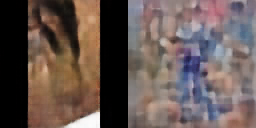

In [359]:
img = iterator.next()[0][0]
vector = encoder.predict(np.array([preprocess_img(img)]))
modified = modifier.predict(vector)
print(cosine(modified[0], vector[0]))
image2 = decoder.predict(modified)[0]
image1 = decoder.predict(vector)[0]
show_array(deprocess_img(np.concatenate([image1, image2], axis=1)))